In [1]:
import sourmash
import csv

In [2]:
ls

README.md                  queries.x.zymomock.csvXXX
gut/                       zymomock/
gut-real.ipynb             zymomock.ipynb
nbhds.x.zymomock.csv       zymomock.zip
queries.x.zymomock.csv


In [4]:
ls gut

gut-nbhds.zip            p8808mo11.abundtrim.sig
gut-queries.zip          transfer-gut.zip


In [5]:
!sourmash gather ./gut/p8808mo11.abundtrim.sig gut/gut-queries.zip -o queries.x.gut.csv --ignore-abundance


== This is sourmash version 4.2.4.dev0+g73aeb155.d20220116. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

selecting default query k=31.
loaded query: p8808mo11... (k=31, DNA)
loaded 1 databases.                                                            

Starting prefetch sweep across databases.
Found 98 signatures via prefetch; now doing gather.

overlap     p_query p_match
---------   ------- -------
5.6 Mbp        2.0%   91.7%    CP048626.1 Blautia producta ATCC 2734...
5.5 Mbp        1.9%   99.6%    HF996869.1 Clostridium hathewayi CAG:...
5.0 Mbp        1.8%   99.6%    DABGPL010000001.1 TPA_asm: Escherichi...
4.6 Mbp        1.6%   83.6%    CZAB01000001.1 [Clostridium] clostrid...
4.2 Mbp        1.5%   66.2%    WTVF01000090.1 Enterocloster aldenens...
4.1 Mbp        1.4%   88.0%    GL834357.1 Clostridium symbiosum WAL-...
3.5 Mbp        1.2%   87.3%    AENW01000060.1 Clostridium sp. HGF2 c...
3.2 Mbp        1.1%   99.3%    JULC01000001.1 Bifidobacterium s

In [6]:
!sourmash gather ./gut/p8808mo11.abundtrim.sig ./gut/gut-nbhds.zip -o nbhds.x.gut.csv --ignore-abundance


== This is sourmash version 4.2.4.dev0+g73aeb155.d20220116. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

selecting default query k=31.
loaded query: p8808mo11... (k=31, DNA)
loaded 1 databases.                                                            

Starting prefetch sweep across databases.
Found 98 signatures via prefetch; now doing gather.

overlap     p_query p_match
---------   ------- -------
9.5 Mbp        3.3%  100.0%    nbhd:CVRR01000001.1 Roseburia faecis ...
8.7 Mbp        3.0%   99.5%    nbhd:NIHW01000001.1 [Ruminococcus] gn...
7.8 Mbp        2.7%  100.0%    nbhd:DABGPL010000001.1 TPA_asm: Esche...
7.6 Mbp        2.7%   99.2%    nbhd:CP048626.1 Blautia producta ATCC...
7.6 Mbp        2.6%   97.8%    nbhd:CZAB01000001.1 [Clostridium] clo...
7.4 Mbp        2.6%   99.6%    nbhd:AENW01000060.1 Clostridium sp. H...
6.8 Mbp        2.4%   99.1%    nbhd:HF996869.1 Clostridium hathewayi...
5.8 Mbp        2.0%   96.4%    nbhd:GL834357.1 Clostridium symb

In [7]:
def get_ident(name):
    "pick off identifier, stripping off nbhd: prefix if present."
    name = name.split(' ')[0]
    if name.startswith('nbhd:'):
        name = name[5:]
    return name

In [8]:
gather1 = []
with open('queries.x.gut.csv', newline="") as fp:
    r = csv.DictReader(fp)
    gather1.extend(r)

full_idents = {}

gather1_d = {}
gather1_keys = []
for row in gather1:
    ident = get_ident(row['name'])
    full_idents[ident] = " ".join(row['name'].split(' ')[:3])
    gather1_d[ident] = row
    gather1_keys.append(ident)

In [9]:
gather2 = []
with open('nbhds.x.gut.csv', newline="") as fp:
    r = csv.DictReader(fp)
    gather2.extend(r)
    

gather2_d = {}
gather2_keys = []
for row in gather2:
    ident = get_ident(row['name'])
    gather2_d[ident] = row
    gather2_keys.append(ident)

In [10]:
metag = sourmash.load_one_signature('gut/p8808mo11.abundtrim.sig', ksize=31)

In [12]:
queries = list(sourmash.load_file_as_signatures('gut/gut-queries.zip'))
queries_d = {}
for ss in queries:
    ident = get_ident(ss.name)
    queries_d[ident] = ss

In [13]:
nbhds = list(sourmash.load_file_as_signatures('gut/gut-nbhds.zip'))
nbhds_d = {}
for ss in nbhds:
    ident = get_ident(ss.name)
    nbhds_d[ident] = ss

In [14]:
remaining_hashes = set(metag.minhash.hashes)
unique_hashes_1x = []
for ident in gather1_keys:
    row = gather1_d[ident]
    match = queries_d[ident]
    match_hashes = set(match.minhash.hashes)
    unique_overlap = remaining_hashes & match_hashes
    #print(ident, len(remaining_hashes), len(unique_overlap), row['unique_intersect_bp'], row['remaining_bp'])
    remaining_hashes -= unique_overlap
    unique_hashes_1x.append((ident, unique_overlap))


In [15]:
remaining_hashes = set(metag.minhash.hashes)
unique_hashes_2x = []
for ident in gather2_keys:
    row = gather2_d[ident]
    match = nbhds_d[ident]
    match_hashes = set(match.minhash.hashes)
    unique_overlap = remaining_hashes & match_hashes
    #print(ident, len(remaining_hashes), len(unique_overlap), row['unique_intersect_bp'], row['remaining_bp'])
    remaining_hashes -= unique_overlap
    unique_hashes_2x.append((ident, unique_overlap))


In [16]:
for (nbhd_ident, nbhd_match) in unique_hashes_2x:
    total = 0
    for (query_ident, query_match) in unique_hashes_1x:
        overlap = query_match & nbhd_match
        
        if overlap:
            print(f"{nbhd_ident} <= {query_ident} - {len(overlap)}")
            total += len(overlap)
    print('xxx', nbhd_ident, len(nbhd_match), total)
    print('---')

CVRR01000001.1 <= CP048626.1 - 5
CVRR01000001.1 <= HF996869.1 - 2
CVRR01000001.1 <= CZAB01000001.1 - 2
CVRR01000001.1 <= WTVF01000090.1 - 1
CVRR01000001.1 <= GL834357.1 - 2
CVRR01000001.1 <= CVRR01000001.1 - 2494
CVRR01000001.1 <= NIHW01000001.1 - 1
CVRR01000001.1 <= CABIYM010000001.1 - 1
CVRR01000001.1 <= FMEP01000075.1 - 4
CVRR01000001.1 <= SPHM01000100.1 - 6
CVRR01000001.1 <= NFLB01000001.1 - 1
CVRR01000001.1 <= CABJAX010000001.1 - 1
CVRR01000001.1 <= HF995324.1 - 9
CVRR01000001.1 <= CP019721.1 - 1
CVRR01000001.1 <= LR793273.1 - 2
CVRR01000001.1 <= CABHOC010000001.1 - 1
CVRR01000001.1 <= RQNR01000100.1 - 1
CVRR01000001.1 <= CYXV01000001.1 - 70
CVRR01000001.1 <= JAAISL010000100.1 - 1
CVRR01000001.1 <= NFJI01000001.1 - 1
CVRR01000001.1 <= NIHV01000001.1 - 1
CVRR01000001.1 <= WNAL01000100.1 - 22
CVRR01000001.1 <= QVGF01000001.1 - 1
CVRR01000001.1 <= PDMO01000909.1 - 1
CVRR01000001.1 <= CAAEKB010000001.1 - 1
xxx CVRR01000001.1 9512 2632
---
NIHW01000001.1 <= CP048626.1 - 6
NIHW01000001.

In [17]:
import plotly.graph_objects as go

In [18]:
def make_fig():
    #labels = obj.make_labels()
    #src_l, dest_l, cnt_l, color_l, label_l = obj.make_lists()
    labels = []
    src_l = []
    dest_l = []
    cnt_l = []
    color_l = []
    label_l = []
    
    source_idx = {}
    for n, (query_ident, _) in enumerate(unique_hashes_1x):
        source_idx[query_ident] = n
        labels.append(full_idents[query_ident])
    dest_idx = {}
    source_idx["unassigned"] = len(unique_hashes_1x)
    labels.append("unassigned")
    base = len(unique_hashes_1x) + 1
    for n, (nbhd_ident, _) in enumerate(unique_hashes_2x):
        dest_idx[nbhd_ident] = base + n
        labels.append(full_idents[nbhd_ident])
        
    #source_idx["unassigned"] = base + n + 1
    
    # iterate over all sinks, account for all sources
    num = 0
    leftovers = []
    for (nbhd_ident, nbhd_match) in unique_hashes_2x:
        total = 0
        for (query_ident, query_match) in unique_hashes_1x:
            overlap = query_match & nbhd_match
        
            if overlap:
                print(f"{nbhd_ident} <= {query_ident} - {len(overlap)}")
                total += len(overlap)
                from_idx = source_idx[query_ident]
                to_idx = dest_idx[nbhd_ident]
                
                src_l.append(from_idx)
                dest_l.append(to_idx)
                cnt_l.append(len(overlap))
                if query_ident == nbhd_ident:
                    color_l.append("lightseagreen")
                else:
                    color_l.append("palevioletred")
                label_l.append("")
    
        print('xxx', nbhd_ident, len(nbhd_match), total)
        leftover = len(nbhd_match) - total
        
        if leftover:
            leftovers.append((nbhd_ident, leftover))

        print('---')
        #break
        num += 1
        if num == 3:
            break
            
    if leftovers:
        for nbhd_ident, leftover in leftovers:
            from_idx = source_idx["unassigned"]
            to_idx = dest_idx[nbhd_ident]

            src_l.append(from_idx)
            dest_l.append(to_idx)
            cnt_l.append(leftover)
            color_l.append("grey")
            label_l.append("")
            print('XYZ', from_idx, to_idx)
        

    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.5),
          label = labels,
          color = "blue"
        ),
        link = dict(
          source = src_l,
          target = dest_l,
          value = cnt_l,
          color = color_l,
          label = label_l,
      ))])
    
    return fig

fig = make_fig()


CVRR01000001.1 <= CP048626.1 - 5
CVRR01000001.1 <= HF996869.1 - 2
CVRR01000001.1 <= CZAB01000001.1 - 2
CVRR01000001.1 <= WTVF01000090.1 - 1
CVRR01000001.1 <= GL834357.1 - 2
CVRR01000001.1 <= CVRR01000001.1 - 2494
CVRR01000001.1 <= NIHW01000001.1 - 1
CVRR01000001.1 <= CABIYM010000001.1 - 1
CVRR01000001.1 <= FMEP01000075.1 - 4
CVRR01000001.1 <= SPHM01000100.1 - 6
CVRR01000001.1 <= NFLB01000001.1 - 1
CVRR01000001.1 <= CABJAX010000001.1 - 1
CVRR01000001.1 <= HF995324.1 - 9
CVRR01000001.1 <= CP019721.1 - 1
CVRR01000001.1 <= LR793273.1 - 2
CVRR01000001.1 <= CABHOC010000001.1 - 1
CVRR01000001.1 <= RQNR01000100.1 - 1
CVRR01000001.1 <= CYXV01000001.1 - 70
CVRR01000001.1 <= JAAISL010000100.1 - 1
CVRR01000001.1 <= NFJI01000001.1 - 1
CVRR01000001.1 <= NIHV01000001.1 - 1
CVRR01000001.1 <= WNAL01000100.1 - 22
CVRR01000001.1 <= QVGF01000001.1 - 1
CVRR01000001.1 <= PDMO01000909.1 - 1
CVRR01000001.1 <= CAAEKB010000001.1 - 1
xxx CVRR01000001.1 9512 2632
---
NIHW01000001.1 <= CP048626.1 - 6
NIHW01000001.

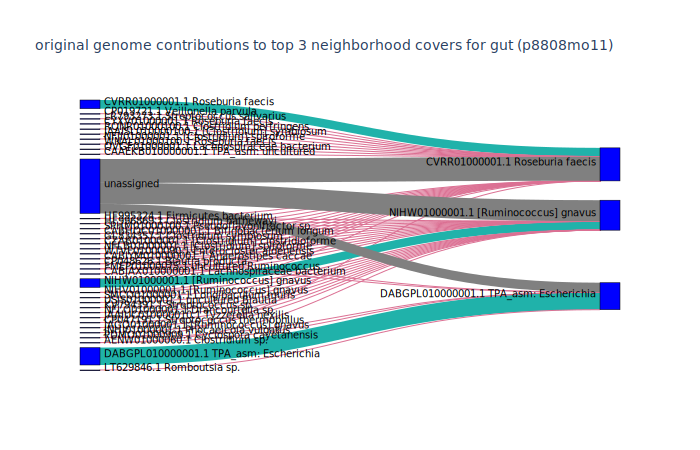

In [20]:
fig.update_layout(title_text="original genome contributions to top 3 neighborhood covers for gut (p8808mo11)", font_size=10)
fig.show("svg")